In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
grodf = pd.read_csv('data/grocery_store_data_cleaned.csv')

In [3]:
grodf['DATE'] = pd.to_datetime(grodf['DATE'])
grodf.set_index('DATE', inplace=True)

In [5]:
grodf.drop(columns='Unnamed: 0',inplace = True)
grodf.columns

Index(['TICKET', 'UNITS', 'REFERENCE', 'CODE', 'NAME', 'UNIT_PRICEBUY',
       'UNIT_PRICESELL', 'PAYMENT', 'TRANSID', 'CATEGORY', 'TOTAL_PRICEBUY',
       'TOTAL_PRICESELL', 'UNIT_PRICE_MARGIN', 'PROFIT'],
      dtype='object')

In [6]:
grodf[grodf.PAYMENT=='free'].sum()

TICKET               9c178cbd-5b82-4981-be92-5e8b26fb14419c178cbd-5...
UNITS                                                           37.866
REFERENCE                                                        82684
CODE                                                       4.20816e+13
NAME                 egg free range 600gCapsicum redGarlic 500gCarr...
UNIT_PRICEBUY                                                     87.4
UNIT_PRICESELL                                                  230.72
PAYMENT              freefreefreefreefreefreefreefreefreefreefreefr...
TRANSID              no IDno IDno IDno IDno IDno IDno IDno IDno IDn...
CATEGORY             EggscapsicumOnionscarrotsMushroomsCitrusPearsO...
TOTAL_PRICEBUY                                                 39.2848
TOTAL_PRICESELL                                                129.662
UNIT_PRICE_MARGIN                                               143.32
PROFIT                                                          90.377
dtype:

In [11]:
grodf.drop(grodf.index[grodf.PAYMENT=='free'],inplace = True)

In [12]:
grodf.PAYMENT.unique()

array(['cash', 'cashrefund', 'magcard'], dtype=object)

In [22]:
grodf.drop(grodf.index[grodf.CATEGORY == 'markdown bag'],inplace = True)

I drop markdown bags

In [23]:
cats = grodf.groupby('CATEGORY')

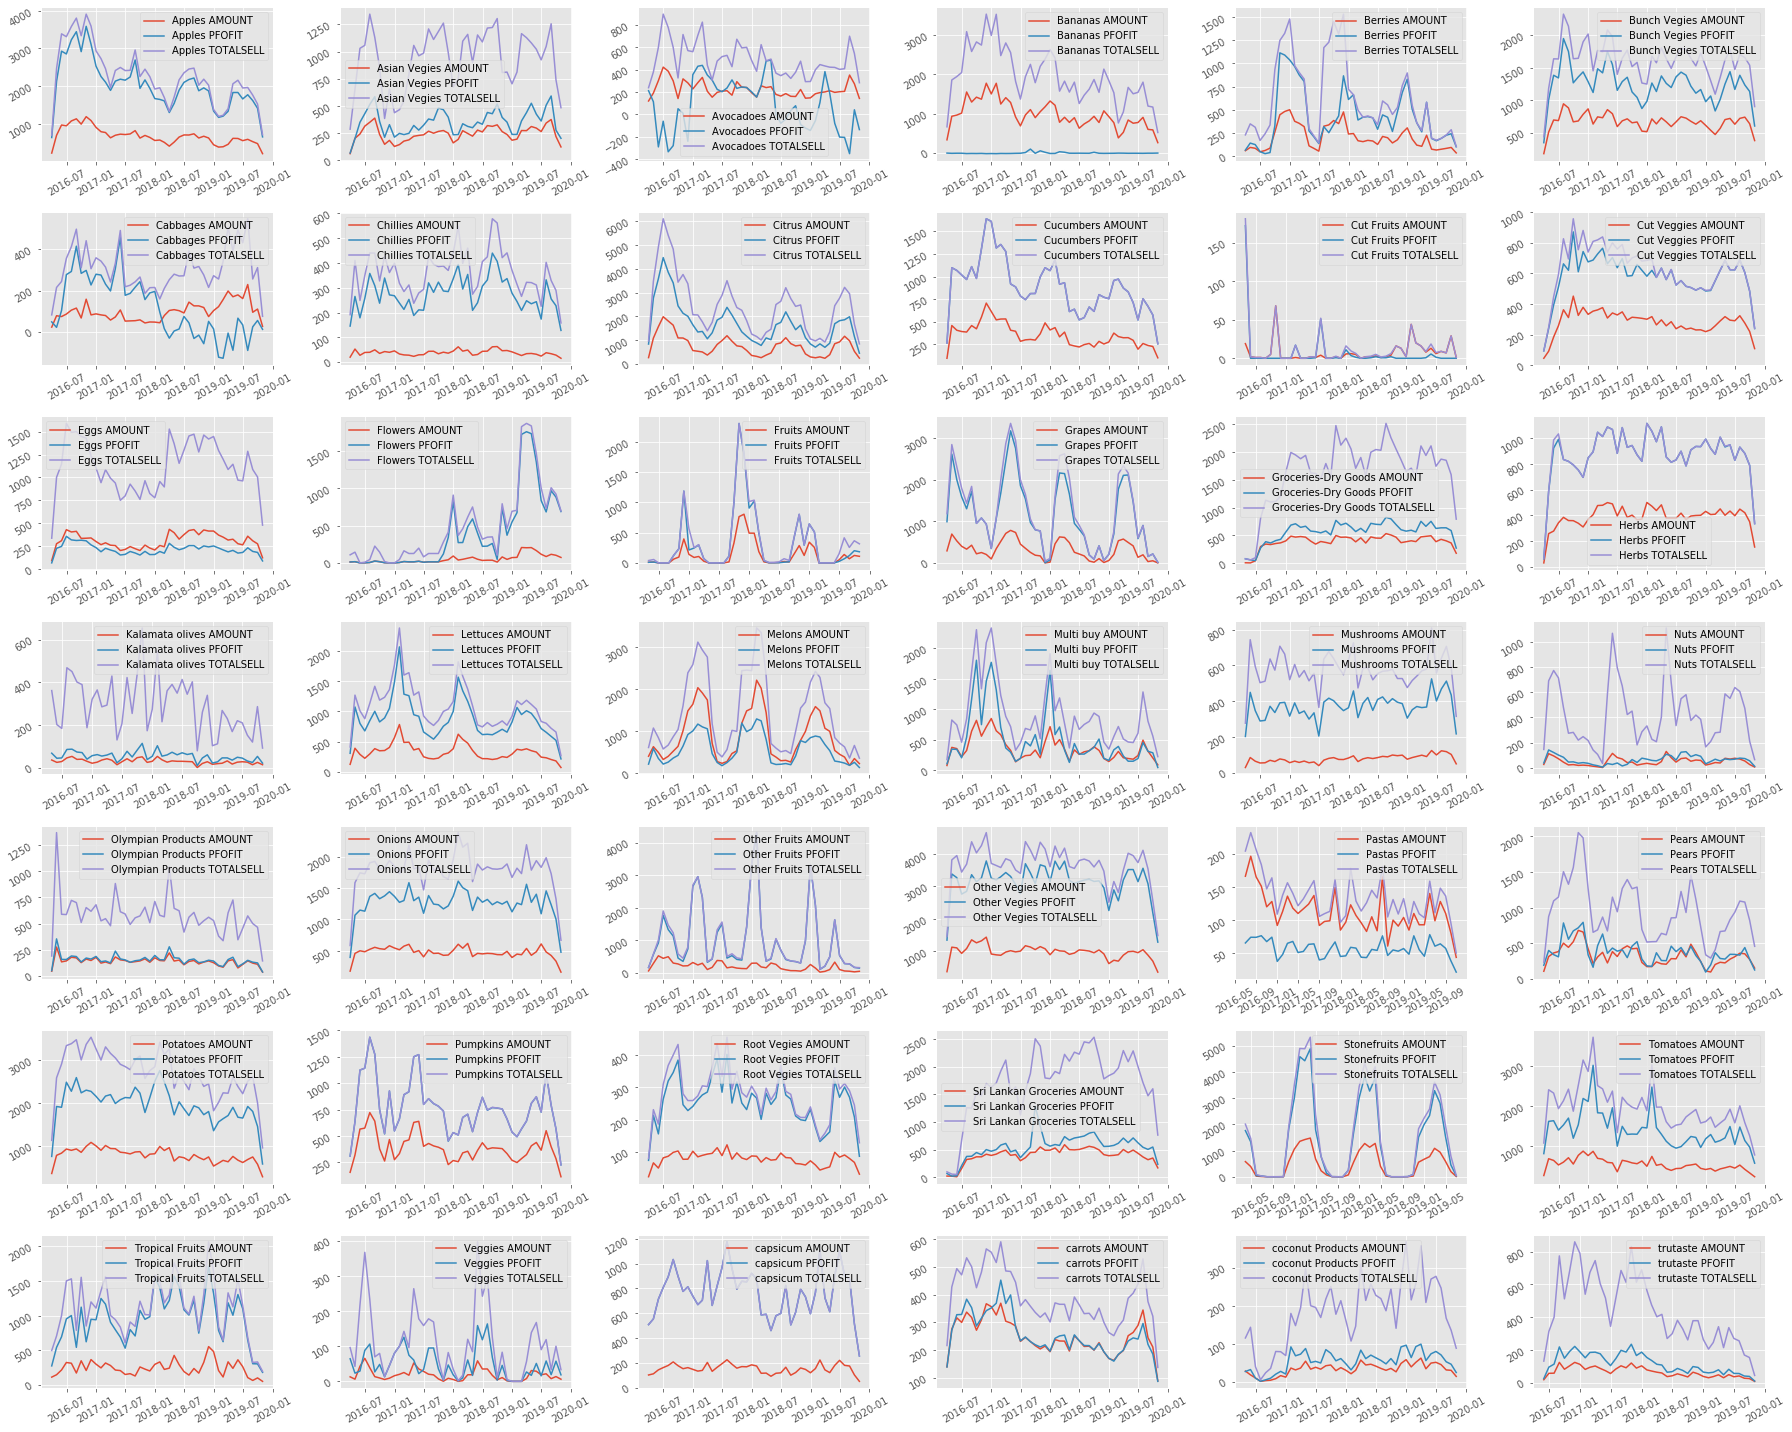

In [24]:
fig, axes = plt.subplots(7,6,figsize = (25,20))
#plt.setp(axes.xaxis.get_majorticklabels(), rotation=45)
for cat,ax in zip(cats, axes.flatten()):
    ax.plot(cat[1].resample('M').sum()['UNITS'], label = cat[0]+' AMOUNT')
    ax.plot(cat[1].resample('M').sum()['PROFIT'], label = cat[0]+' PFOFIT')
    ax.plot(cat[1].resample('M').sum()['TOTAL_PRICESELL'], label = cat[0]+' TOTALSELL')
    ax.legend()
    ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

In [179]:
seasonal_decompose?

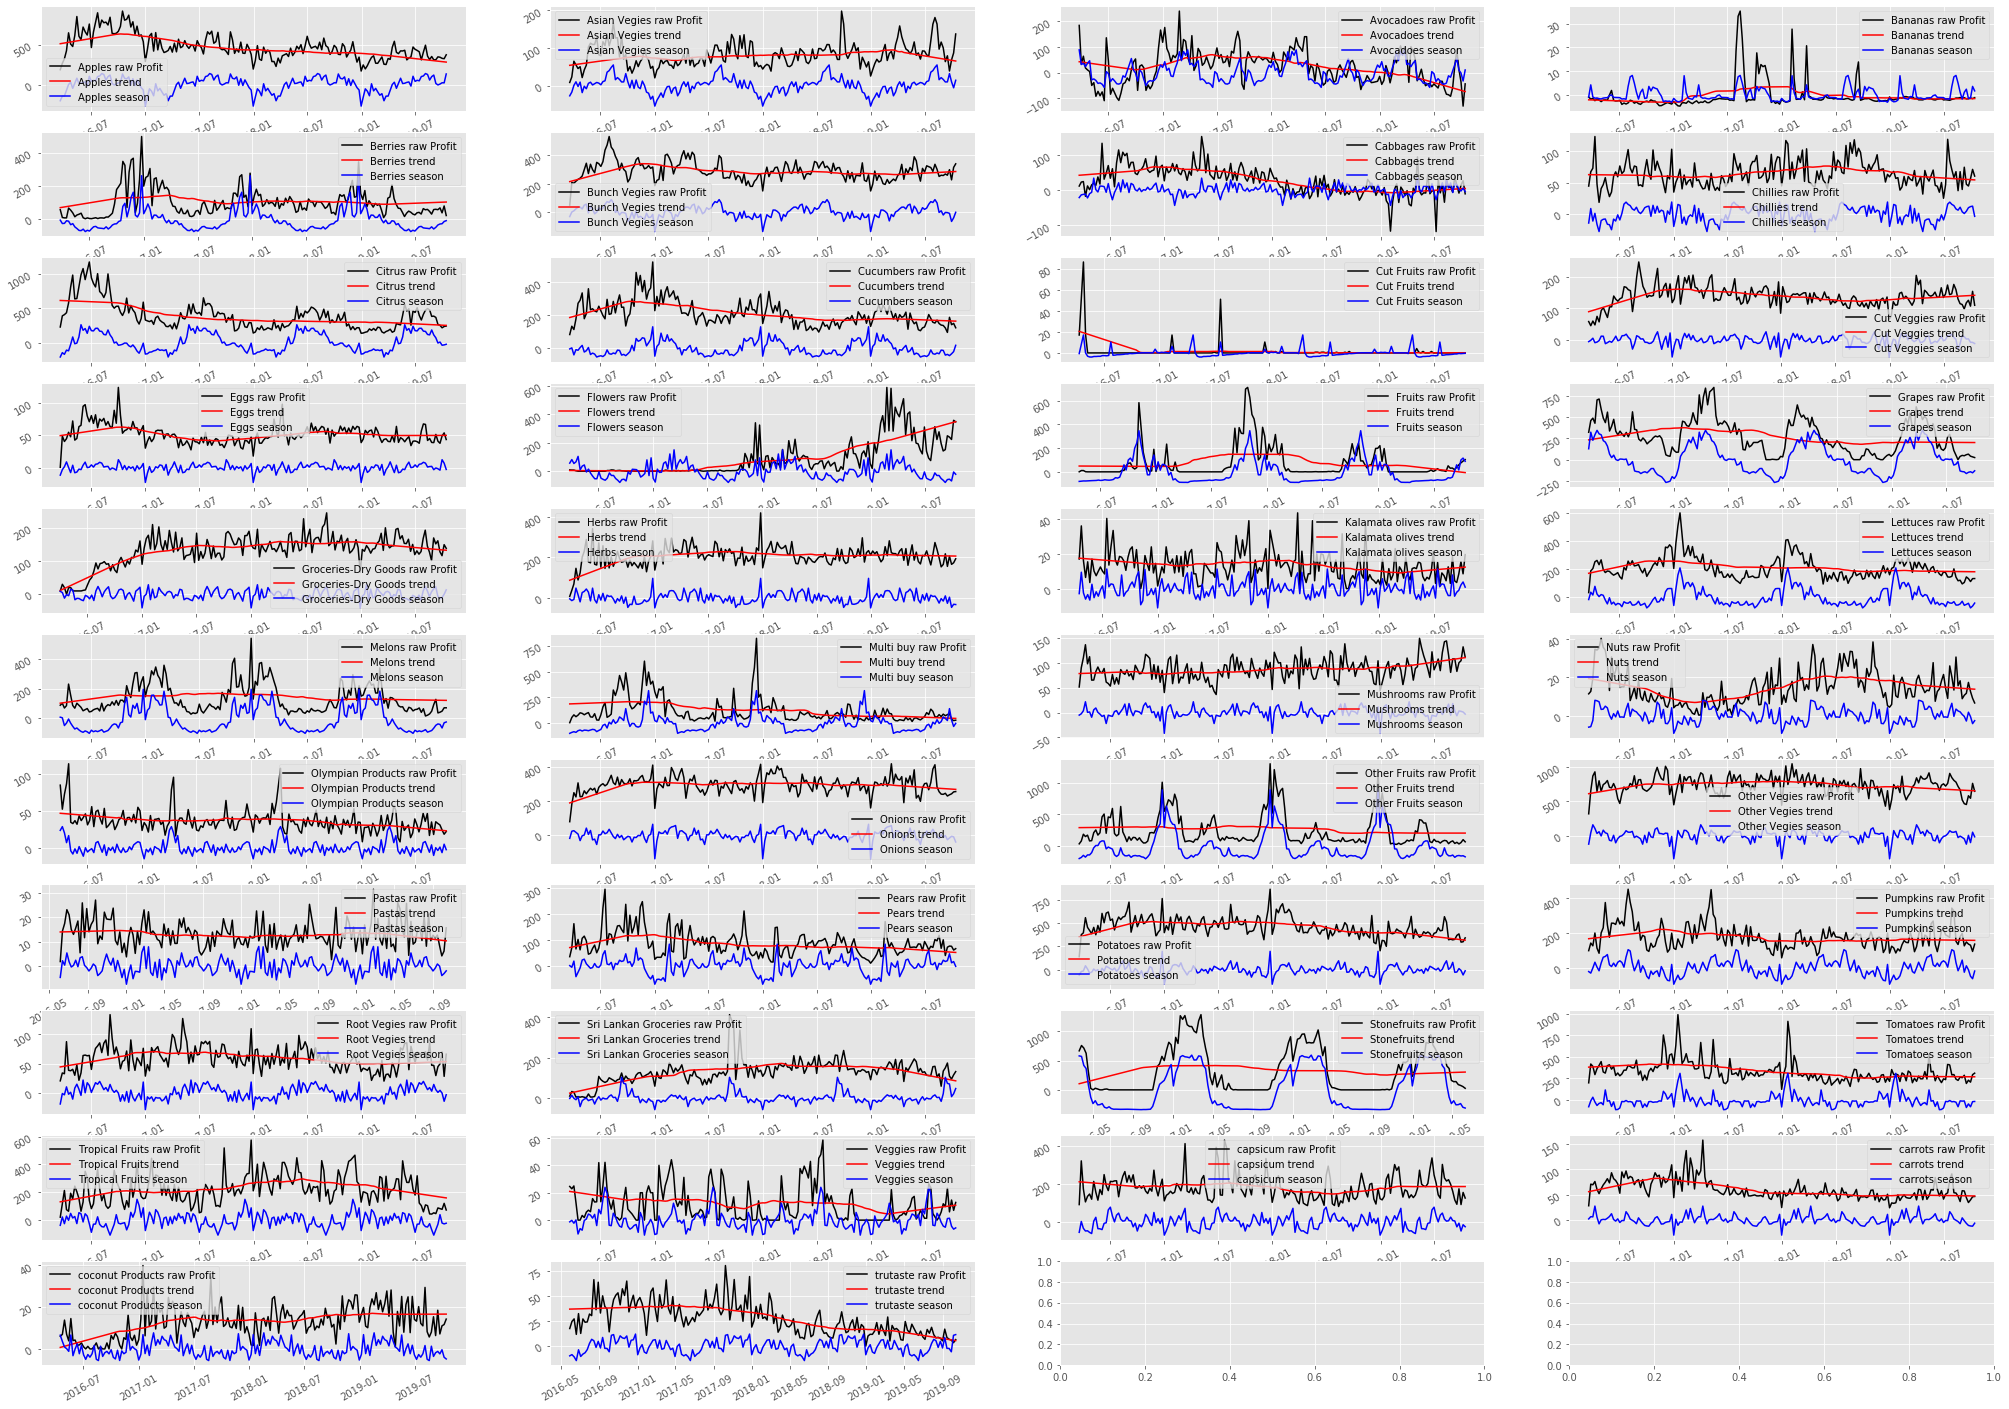

In [186]:
fig, axes = plt.subplots(11,4,figsize = (35,25))
#plt.setp(axes.xaxis.get_majorticklabels(), rotation=45)
for cat,ax in zip(cats, axes.flatten()):
    ser = cat[1].resample('W').sum()['PROFIT']
    decomposition = seasonal_decompose(ser,extrapolate_trend=1)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    ax.plot(ser, label = cat[0]+' raw Profit', color = 'black')
    ax.plot(trend, label = cat[0]+' trend', color = 'red')
    ax.plot(seasonal, label = cat[0]+' season', color = 'blue')
    ax.legend()
    ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.savefig('testik.png')


<Figure size 432x288 with 0 Axes>

lets try to create some model
starts with one category
say pears

In [25]:
pears = grodf[grodf.CATEGORY == 'Pears']
pears.shape

(15554, 14)

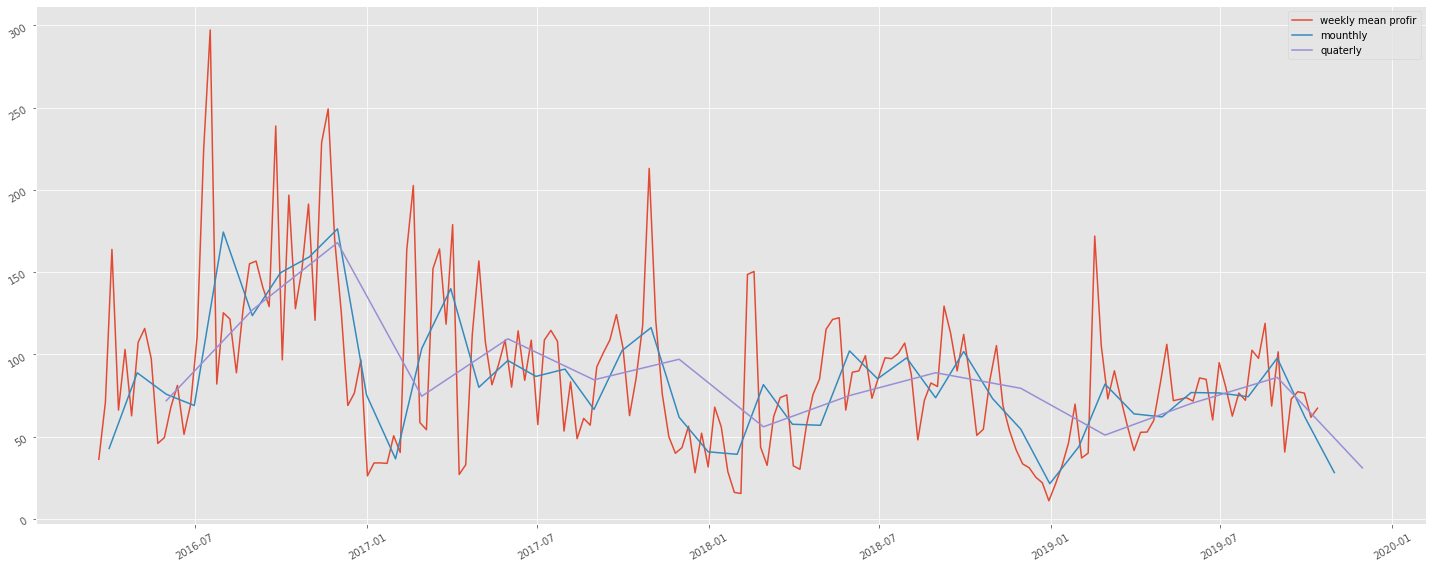

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(pears.resample('W').sum()['PROFIT'], label = 'weekly mean profir')
ax.plot(pears.resample('M').sum()['PROFIT']/4.5, label = 'mounthly')
ax.plot(pears.resample('Q-NOV').sum()['PROFIT']/13, label = 'quaterly')

ax.legend()
ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

Naive prediction for next 3 month profit --- 1000 - 1500

In [38]:
pears_prof_week = pears.resample('W').sum()['PROFIT']

In [40]:
len(pears_prof_week)

187

In [ ]:
decomposition = seasonal_decompose(pears_prof_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [86]:
plt.subplot(411)
plt.plot(pears_prof_week, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [121]:
pear_diff = pears_prof_week.diff()[1:]
test = sm.tsa.stattools.adfuller(pear_diff)
print("ADF p-value for differenced pear series: {0:2.2f}".format(test[1]))

ADF p-value for differenced pear series: 0.00


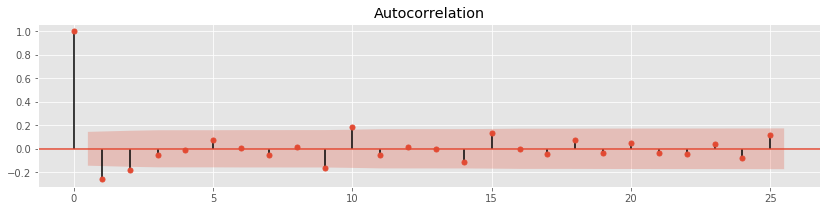

In [91]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(pear_diff, lags=25, ax=ax)

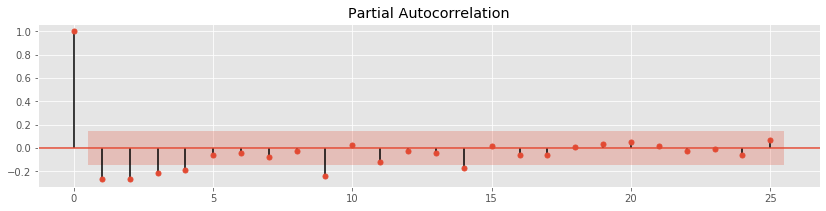

In [96]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(pear_diff, lags=25, ax=ax)

In [217]:
pear_model = ARIMA(pears_prof_week[:-10], order=(3, 1, 1)).fit()

In [218]:
print(pear_model.params)

const            -0.307002
ar.L1.D.PROFIT    0.479390
ar.L2.D.PROFIT   -0.064610
ar.L3.D.PROFIT    0.090963
ma.L1.D.PROFIT   -0.999940
dtype: float64


In [219]:
start = pears_prof_week.index[-10]
end = pears_prof_week.index[-1]
start,end

(Timestamp('2019-08-11 00:00:00', freq='W-SUN'),
 Timestamp('2019-10-13 00:00:00', freq='W-SUN'))

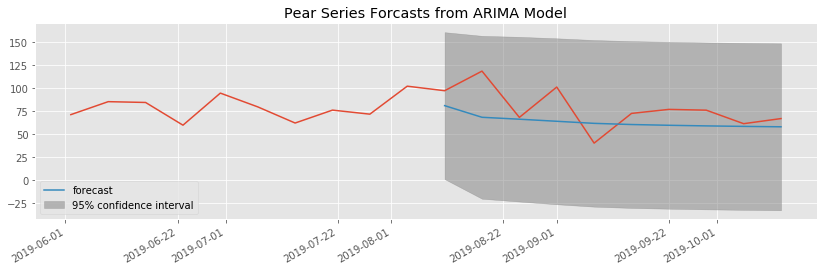

In [220]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(pears_prof_week.index[-20:], pears_prof_week[-20:])
fig = pear_model.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear Series Forcasts from ARIMA Model")

In [221]:
pear_model.predict(start, '2019-10-31')

2019-08-11   -21.152320
2019-08-18   -12.657930
2019-08-25    -2.086098
2019-09-01    -2.258045
2019-09-08    -2.250844
2019-09-15    -1.274636
2019-09-22    -0.822758
2019-09-29    -0.668550
2019-10-06    -0.535020
2019-10-13    -0.439867
2019-10-20    -0.388852
2019-10-27    -0.358397
2019-11-03    -0.338438
Freq: W-SUN, dtype: float64

In [222]:
pear_pred = pear_model.predict(start,end)

In [223]:
pe_prof_pred  = pear_pred.cumsum() +pears_prof_week[-11]

In [144]:
last = pears_prof_week[-11]

In [166]:
parameters = [
    {'AR': 5, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 5, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(pears_prof_week, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(5, 1, 0) AIC: 1930.8717278803456
ARIMA(3, 1, 1) AIC: 1916.705344514336
ARIMA(4, 1, 0) AIC: 1929.486037454024
ARIMA(4, 1, 1) AIC: 1917.899154604852
ARIMA(5, 1, 1) AIC: 1918.8169031065017


In [ ]:
3,1,1 better

In [172]:
pears_prof_week.index[-1]

Timestamp('2019-10-13 00:00:00', freq='W-SUN')

### By amount

In [188]:
p_am = pears.resample('W').sum()['UNITS']
p_pr = pears.resample('W').mean()['UNIT_PRICESELL']- pears.resample('W').mean()['UNIT_PRICEBUY']

In [189]:
decomposition_am  = seasonal_decompose(p_am)
decomposition_pr  = seasonal_decompose(p_pr)

trend_p = decomposition_pr.trend
seasonal_p = decomposition_pr.seasonal
residual_p = decomposition_pr.resid

trend_a = decomposition_am.trend
seasonal_a = decomposition_am.seasonal
residual_a = decomposition_am.resid

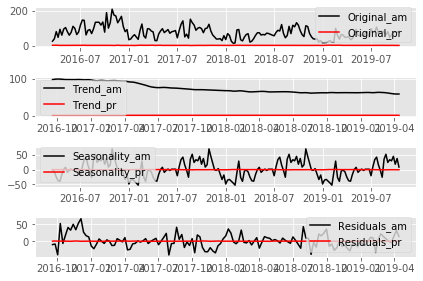

In [190]:
plt.subplot(411)
plt.plot(p_am, label='Original_am', color  = 'black')
plt.plot(p_pr, label='Original_pr', color  = 'red')

plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_a, label='Trend_am',color  = 'black')
plt.plot(trend_p, label='Trend_pr', color  = 'red')

plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_a,label='Seasonality_am', color  = 'black')
plt.plot(seasonal_p,label='Seasonality_pr',color  = 'red')

plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_a, label='Residuals_am', color  = 'black')
plt.plot(residual_p, label='Residuals_pr', color  = 'red')

plt.legend(loc='best')
plt.tight_layout()

In [233]:
p_a_mod = ARIMA(p_am[:-10], order=(3, 1, 1)).fit()
p_pr_mod = ARIMA(p_pr[:-10], order=(3, 1, 1)).fit()

In [234]:
### dont change
start = pears_prof_week.index[-10]
end = pears_prof_week.index[-1]
start,end

(Timestamp('2019-08-11 00:00:00', freq='W-SUN'),
 Timestamp('2019-10-13 00:00:00', freq='W-SUN'))

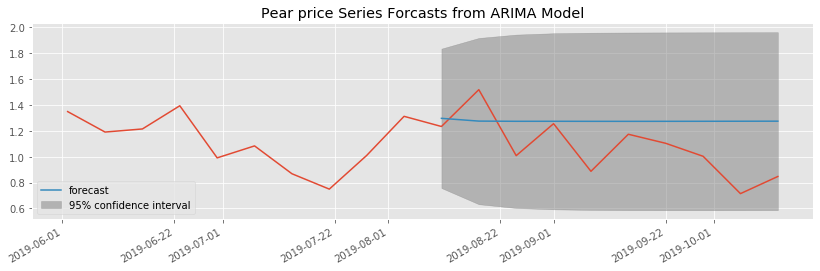

In [236]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(p_pr.index[-20:], p_pr[-20:])
fig = p_pr_mod.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear price Series Forcasts from ARIMA Model")

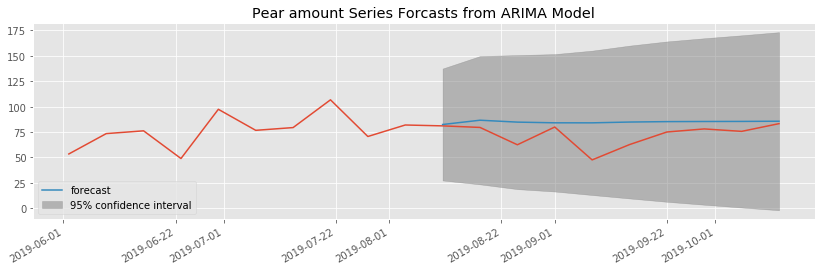

In [237]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(p_am.index[-20:], p_am[-20:])
fig = p_a_mod.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear amount Series Forcasts from ARIMA Model")

In [238]:
am_pred = p_a_mod.predict(start,end)
pr_pred = p_pr_mod.predict(start,end)
last_pr = p_pr[-11]
last_am = p_am[-11]
am_pred_c = last_am+am_pred.cumsum()
pr_pred_c = last_pr+pr_pred.cumsum()

In [239]:
new_prof_pred = am_pred_c*pr_pred_c

In [240]:
from sklearn.metrics import mean_squared_error

In [241]:
mean_squared_error(p_am[-10:],am_pred_c), mean_squared_error(p_am[-10:],np.array(10*[last_am]))

(264.2487032192279, 203.94405200000014)

In [242]:
new_prof_half_flat = np.array(10*[last_am])*pr_pred_c

In [243]:
mean_squared_error(p_pr[-10:],pr_pred_c), mean_squared_error(p_pr[-10:],np.array(10*[last_pr]))

(0.08896965442357123, 0.10546183983167998)

In [244]:
mean_squared_error(pears_prof_week[-10:],pe_prof_pred) ,mean_squared_error(pears_prof_week[-10:], np.array(10*[pears_prof_week[-11]]))

(545.6317484730528, 1036.8001309013603)

In [245]:
mean_squared_error(pears_prof_week[-10:],new_prof_pred), mean_squared_error(pears_prof_week[-10:],new_prof_half_flat)

(1338.2312526609808, 1132.7657853920673)

## Coconut

In [253]:
coco = grodf[grodf.CATEGORY == 'coconut Products'].resample('W').sum()['PROFIT']

In [258]:
coc_diff = coco.diff()[1:]
test = sm.tsa.stattools.adfuller(coc_diff[:-10])
print("ADF p-value for differenced pear series: {0:2.2f}".format(test[1]))

ADF p-value for differenced pear series: 0.00


In [232]:
### Without pictures

In [259]:
parameters = [
    {'AR': 5, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 5, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(coco[:-10], order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(5, 1, 0) AIC: 1155.273685783469
ARIMA(3, 1, 1) AIC: 1147.0288916899271
ARIMA(4, 1, 0) AIC: 1154.073572415682
ARIMA(4, 1, 1) AIC: 1149.0277611292358
ARIMA(5, 1, 1) AIC: 1148.0774991886367


In [260]:
coc_mod = ARIMA(coco[:-10], order = (3,1,1)).fit()

In [262]:
coc_pred = coco[-11] +coc_mod.predict(start,end).cumsum()
coc_base = np.ones(10)*coco[-11]

In [263]:
mean_squared_error(coco[-10:], coc_pred), mean_squared_error(coco[-10:], coc_base)

(102.0819623917814, 370.0326900000001)

## For all categories

1. Lets do ARIMA(order = (3,1,1)) for each category. Also compare with base prediction (last profit)
    Do twice???
2. Look at MSE for last 10 week
3. refit on whole dataset and do prediction for next 12 weeks

In [272]:
def base_model(df, last, length):
    times = df.resample('W').sum()['PROFIT']
    return np.ones(length)*times[last]

In [306]:
def Arima311(df, last, start,end):
    times = df.resample('W').sum()['PROFIT']
    if df['CATEGORY'].unique()[0] in['Grapes', 'Stonefruits']:
        return np.ones(-last-1)*times[last]
    
    mod = ARIMA(times[:last+1], order = (3,1,1)).fit()
    pred = times[last]+mod.predict(start,end).cumsum()
    return pred

In [315]:
def true_prof(df, last):
    times = df.resample('W').sum()['PROFIT']
    return times[last+1:]

In [274]:
base_pr_cat = grodf.groupby('CATEGORY').apply(base_model, last = -11, length = 10)

In [283]:
cats = grodf.groupby('CATEGORY')


In [298]:
def ccc(df):
    if df['CATEGORY'].unique()[0] in['Grapes', 'Stonefruits']:
        print('!!!')


In [299]:
for cat in cats:
    ccc(cat[1])

!!!
!!!


In [292]:
def chekin_her(df):
    r = df.resample('W').sum()['PROFIT']
    return [len(r), r.index[-11],r.index[-10]]

In [293]:
"""for cat in cats:
    r = cat[1].resample('W').sum()['PROFIT']
    print(cat[0],len(r), r.index[-11], r.index[-10])"""
her = cats.apply(chekin_her)
her

CATEGORY
Apples                  [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Asian Vegies            [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Avocadoes               [186, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Bananas                 [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Berries                 [186, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Bunch Vegies            [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Cabbages                [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Chillies                [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Citrus                  [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Cucumbers               [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Cut Fruits              [184, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Cut Veggies             [186, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Eggs                    [187, 2019-08-04 00:00:00, 2019-08-11 00:00:00]
Flowers                 [186, 2019-08-04 00:00:00, 2019

In [319]:
names = []
prof = []
arima = []
mse = []

In [320]:
for cat in cats:
    p_ar = Arima311(cat[1],last = -11, start = start, end = end)
    p_bas = base_model(cat[1], last = -11, length = 10)
    p_true = true_prof(cat[1], last = -11)
    m_ar = mean_squared_error(p_true, p_ar)
    m_b = mean_squared_error(p_true, p_bas)
    names.append(cat[0])
    arima.append(m_b>=m_ar)
    mse.append(min(m_b,m_ar))
    pr = sum(p_ar) if m_ar <= m_b else sum(p_bas)
    prof.append(pr)

In [321]:
profit_10w = pd.DataFrame({'CATEGORY':names, 'PROFIT':prof, 'MSE':mse, 'IS_ARIMA':arima})
profit_10w.head()

,CATEGORY,PROFIT,MSE,IS_ARIMA
0,Apples,4000.181629,4710.088903,True
1,Asian Vegies,1472.974219,3887.112197,True
2,Avocadoes,-225.182137,3989.488573,True
3,Bananas,-16.011874,0.089069,True
4,Berries,529.635205,294.067022,True


In [326]:
profit_10w.to_csv('last_10week_predicted_prof.csv')

### By month

In [151]:
pears_prof_month = pears.resample('M').sum()['PROFIT']

In [152]:
decomposition = seasonal_decompose(pears_prof_month)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

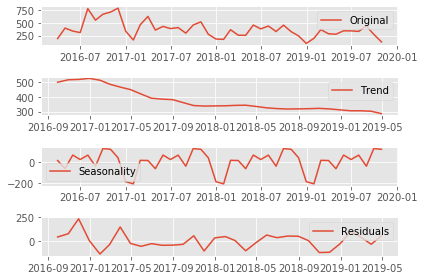

In [153]:
plt.subplot(411)
plt.plot(pears_prof_month, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [154]:
len(pears_prof_month)

44

In [158]:
pear_model_m = ARIMA(pears_prof_month[:-5], order=(3, 1, 0)).fit()
start = pears_prof_month.index[-5]
end = pears_prof_month.index[-1]
start,end

(Timestamp('2019-06-30 00:00:00', freq='M'),
 Timestamp('2019-10-31 00:00:00', freq='M'))

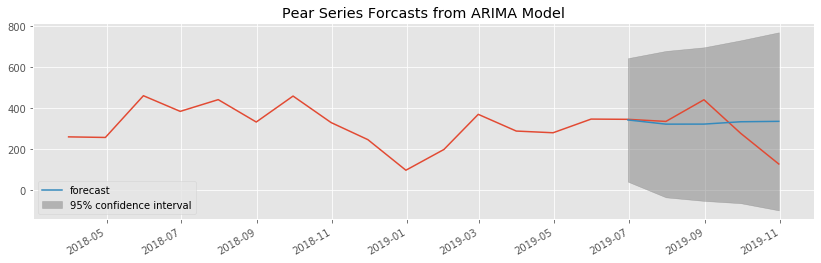

In [160]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(pears_prof_month.index[-20:], pears_prof_month[-20:])
fig = pear_model_m.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear Series Forcasts from ARIMA Model")

In [164]:
mp = pear_model_m.predict(start, end).cumsum()+pears_prof_month[-6]
mp

2019-06-30    341.386476
2019-07-31    320.846106
2019-08-31    321.062475
2019-09-30    332.478871
2019-10-31    334.516567
Freq: M, dtype: float64

In [165]:
mp.sum(), pears_prof_month[-5:].sum()

(1650.2904939861046, 1520.6634)

In [167]:
parameters = [
    {'AR': 5, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 5, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(pears_prof_month, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(5, 1, 0) AIC: 564.7128196555684
ARIMA(3, 1, 1) AIC: 564.2197372978571
ARIMA(4, 1, 0) AIC: 564.1176866919648
ARIMA(4, 1, 1) AIC: 565.8427823057604
ARIMA(5, 1, 1) AIC: 568.342906784093
